# Traffic Sign Identification using Deep Neural Networks

## Description
Lorem Ipsum

## Setup and Image Preprocessing

### Imports

In [3]:
import cv2
import pickle
import csv
from skimage import exposure

### Preprocessing Function
Preprocesses images according to passed parameters.

In [2]:
def preprocess_images(file_name, grayscale = False, equalize = None, normalize=False, contrast = False):
    path = './Dataset/'   # Change this for the path corresponding to your base Dataset directory

    img_infos = {'labels':[],'images':[]}

    with open(path+file_name,"r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',', quotechar='|')
        next(reader)
        
        for row in reader:

            img = cv2.imread(path+row[-1], cv2.IMREAD_UNCHANGED) 
            
            if contrast and exposure.is_low_contrast(img, fraction_threshold=0.1, upper_percentile=90):
                img = exposure.adjust_gamma(img, 0.5)
            
            if normalize:
                cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Normalize
                
            if equalize is not None:
                img = equalize(img)
                
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image to Grayscale
            
            img = cv2.resize(img, (32,32),interpolation = cv2.INTER_AREA) #Resize the image to 32x32
            
            img_infos['images'].append(img) #Save Image pixels
            img_infos['labels'].append(row[-2]) #Save image Label
            
            
    return img_infos

### Save treated data as Pickle
Saves the treated data into Pickle files

In [3]:
# Normalized Grayscale
test_gray = preprocess_images("Test.csv", grayscale=True, normalize=True)

with open("./Dataset/PickledData/Test_normalize.p", 'wb') as pickle_rick:
    pickle.dump(test_gray,pickle_rick)    
print("> Finished writing tests")

train_gray = preprocess_images("Train.csv", grayscale=True, normalize=True)
with open("./Dataset/PickledData/Train_normalize.p", 'wb') as pickle_rick:
    pickle.dump(train_gray,pickle_rick)
print("> Finished writing train")

> Finished writing tests
> Finished writing train


## Neural Network

### Step 0 - Imports

In [57]:
import random
import numpy as np
import pickle
import cv2

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from skimage import transform, exposure

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1 - Get the data into the sets

In [58]:
def augment_img(img):
    img = transform.rotate(img, random.uniform(-45,45))
    img = exposure.adjust_gamma(img, random.uniform(0.5, 1.5))
    return img


def augment_set(x_set, y_set):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
        
    for i in range(len(y_set)):
        label_dic[str(y_set[i])].append(x_set[i])
    
    for i in label_dic:
        while len(label_dic[i]) < 1500:
            rand_index = random.randint(0, len(label_dic[i]) -1)
            label_dic[i].append(augment_img(label_dic[i][rand_index]))
    
    aug_x = []
    aug_y = []
    for label in label_dic:
        for img in label_dic[label]:
            aug_y.append(int(label))
            aug_x.append(img)
    return aug_x, aug_y
    

In [59]:
def create_cv_random(x_train, y_train):
    # Get the cross validation set
    x_cv = []
    y_cv = []
    for i in range(int(0.2*len(x_train))): # Randomly move 20% of the training examples into the cross-validation set
        index = random.randint(0, len(x_train)-1)
        x_cv.append(x_train.pop(index))
        y_cv.append(y_train.pop(index))
        
    return x_cv, y_cv

def create_cv_equitative(x_train, y_train):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
    
    for i in range(len(y_train)):
        label_dic[str(y_train[i])].append(x_train[i])
    
    x_cv = []
    y_cv = []
    for label in label_dic:
        for i in range(int(0.2*len(label_dic[label]))):
            index = random.randint(0, len(label_dic[label]) -1)
            y_cv.append(int(label))
            x_cv.append(label_dic[label].pop(index))
        
    x_train = []
    y_train = []
    for label in label_dic:
        for img in label_dic[label]:
            y_train.append(int(label))
            x_train.append(img)
    x_cv, y_cv = shuffle(x_cv, y_cv)
    return x_cv, y_cv, x_train, y_train

def open_set(path_test, path_train, gray = False, cv_random = True, augment=False):

    with open(path_test, "rb") as f:
        test = pickle.load(f)
    with open(path_train, "rb") as f:
        train = pickle.load(f)

    # Get the training set
    x_train, y_train = train['images'], train['labels']
    
    if augment:
        #Normalize images
        x_train, y_train= augment_set(x_train, y_train)

        print("finished augmenting set")

    # Get the cross validation set
    if cv_random:
        x_cv, y_cv = create_cv_random(x_train, y_train)
    else:
        x_cv, y_cv, x_train, y_train = create_cv_equitative(x_train, y_train)

    # Get the test set
    x_test, y_test = test['images'], test['labels']

    # Convert all our sets into numPy Arrays
    if gray:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 1))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 1))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 1))
        y_test = keras.utils.to_categorical(np.array(y_test))
    else:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 3))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 3))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 3))
        y_test = keras.utils.to_categorical(np.array(y_test))
    
    
    
    return x_test, y_test, x_train, y_train, x_cv, y_cv

In [60]:
x_test, y_test, x_train, y_train, x_cv, y_cv = open_set("./Dataset/PickledData/Test_normalize.p", "./Dataset/PickledData/Train_normalize.p", gray=True, cv_random=False, augment=True)

finished augmenting set


### Step 2 - Treat the data (Augment and Shuffle)

In [61]:

# Shuffle the training set
x_train, y_train = shuffle(x_train, y_train)


### Step 3 - Define constants

In [62]:
EPOCHS = 50
BATCH_SIZE = 200
LOSS = keras.losses.categorical_crossentropy
OPT = keras.optimizers.Adam
LEARNING_RATE = 0.002 # Define the learning rate to be used by our optimizer


### Step 4 - Define the Neural Network

In [63]:
def LeNetModel(no_output=6, rgb=True, dropout=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
    
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    # Third Layer - Convolutional ; Input = 14x14x6 ; Output = 10x10x16
    model.add(keras.layers.Conv2D(
                    filters=16, kernel_size=(3, 3),
                    activation='relu'
                    )
                 )
    
    # Fourth Layer - Subsampling (Average Pooling) ; Input = 10x10x16 ; Output = 5x5x16
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))

    # Sixth Layer - Fully Connected ; Input = 120x1 ; Output = 84x1
    model.add(keras.layers.Dense(units=84, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

### Step 5 - Create the model and define evaluation

In [80]:
model = LeNetModel(rgb=False)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Step 6 - Insert the training set

In [81]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Train on 55320 samples, validate on 13830 samples
Epoch 1/50
55320/55320 [==============================] - 5s 91us/sample - loss: 2.4193 - accuracy: 0.3912 - val_loss: 1.6490 - val_accuracy: 0.5518
Epoch 2/50
55320/55320 [==============================] - 5s 86us/sample - loss: 1.4338 - accuracy: 0.6049 - val_loss: 1.2825 - val_accuracy: 0.6474
Epoch 3/50
55320/55320 [==============================] - 5s 85us/sample - loss: 1.1086 - accuracy: 0.6832 - val_loss: 1.0772 - val_accuracy: 0.6991
Epoch 4/50
55320/55320 [==============================] - 5s 85us/sample - loss: 0.9105 - accuracy: 0.7383 - val_loss: 0.8726 - val_accuracy: 0.7537
Epoch 5/50
55320/55320 [==============================] - 5s 82us/sample - loss: 0.7711 - accuracy: 0.7753 - val_loss: 0.7845 - val_accuracy: 0.7793
Epoch 6/50
55320/55320 [==============================] - 5s 82us/sample - loss: 0.7059 - accuracy: 0.7937 - val_loss: 0.6780 - val_accuracy: 0.8076
Epoch 7/50
55320/55320 [==============================] 

## Graphs

### Confusion Matrix

In [66]:
def create_confusion_matrices(y_test, y_predictions):
    #Absolute matrix (number of guesses)
    conf_mat_abs = confusion_matrix(np.argmax(y_test, axis=1), y_predictions)

    #Relative matrix (normalized number of guesses (0-1))
    conf_mat_rel = conf_mat_abs.astype('float') / conf_mat_abs.sum(axis=1)[:, np.newaxis]
    
    return conf_mat_abs, conf_mat_rel

### Confusion Matrix Visualized

In [67]:
def plot_confusion(conf_matrix, title):
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(43)],
                      columns = [i for i in range(43)])
    plt.figure(figsize = (22,22))
    
    ax = sn.heatmap(df_cm, annot=False)
    
    plt.ylabel('Actual Class', fontsize=15)
    plt.xlabel("Guessed Class", fontsize=15)
    
    ax.collections[0].colorbar.set_label("Probability of Guess (%)", fontsize=15)
    plt.title(title,fontsize=18)

    plt.show()

### Histogram of Accuracy per Class

In [68]:
def plot_acc_per_class(conf_mat):
    plt.figure(figsize = (7.25,6))
    plt.bar(range(0,43), [conf_mat_rel[i][i] for i in range(43)], color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('Accuracy of guess (%)',fontsize=12)
    plt.title('Accuracy of model per class',fontsize=15)
    plt.show()

### Histogram of CV Distribution

In [69]:
def plot_cv_per_class(y_cv, y_train):
    plt.figure(figsize = (20,7))
    
    plt.subplot(1,2,1)
    plt.hist(np.argmax(y_cv, axis=1), bins = range(0,44), color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the CV Set',fontsize=15)

    
    plt.subplot(1,2,2)
    plt.hist(np.argmax(y_train, axis=1), bins = range(0,44), color="#731f58")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the Train Set',fontsize=15)


    plt.show()

## Discussion of Results


### 1 - RGB

#### Accuracy and Cost

In [65]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 68us/sample - loss: 1.5383 - accuracy: 0.8914
Train loss: 0.03132440663282988
Train accuracy: 0.9918069
CV loss: 0.2507336913898897
CV accuracy: 0.96977425
Test loss: 1.538338404115782
Test accuracy: 0.89136976


#### Conf Mat

[[ 20   3   0 ...   0   0   0]
 [  3 643   5 ...   1   0   0]
 [  0  13 678 ...   0   0   0]
 ...
 [  0   0   0 ...  40   2   0]
 [  0   0   0 ...   0  50   0]
 [  0   0   0 ...   0  12  77]]


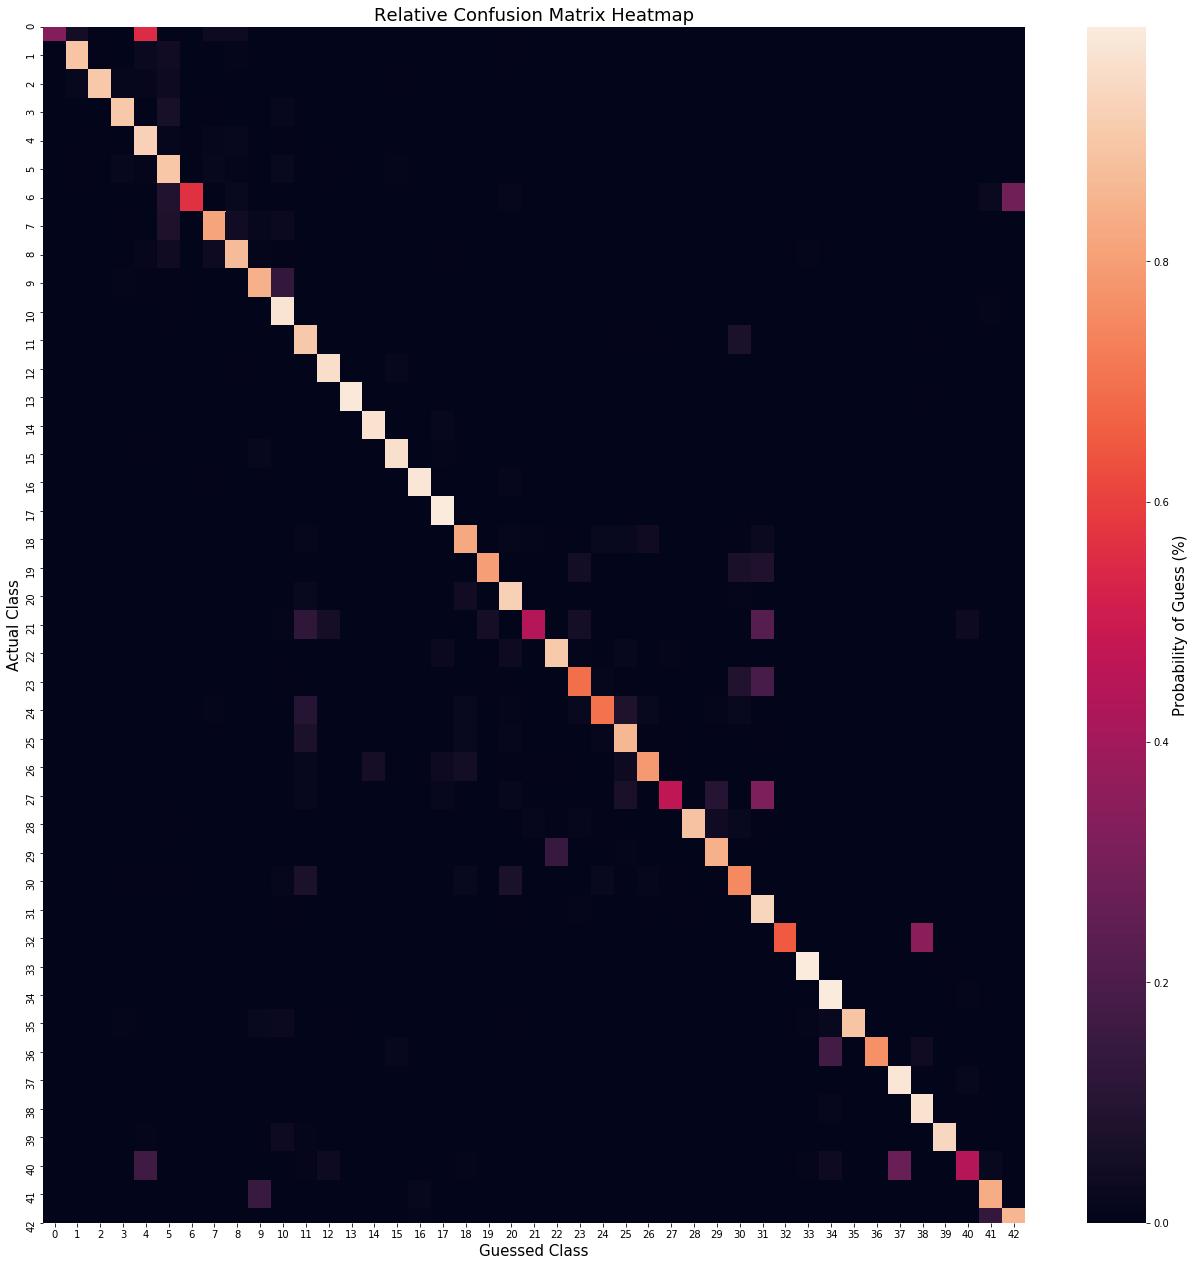

In [66]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per class

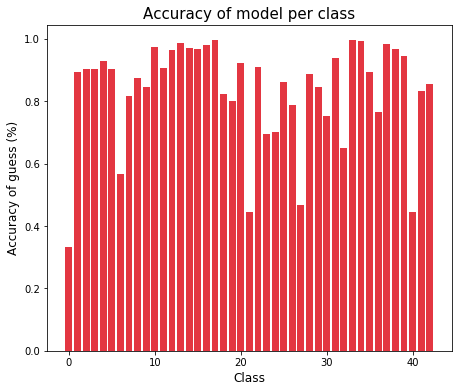

In [67]:
plot_acc_per_class(conf_mat_rel)

### 2 - CV
We noticed that when picking the CV set's elements just by getting 20% of the elements of the total training set we could cause our CV to contain little to no data from some classes, and too much from others. So we changed it in order to assure that our CV is constitued of 20% of each of the train set's classes' data.
As a result, the graph representing the distribution of number of elements per class in each set should be more similar

#### CV Class Distribution with Random

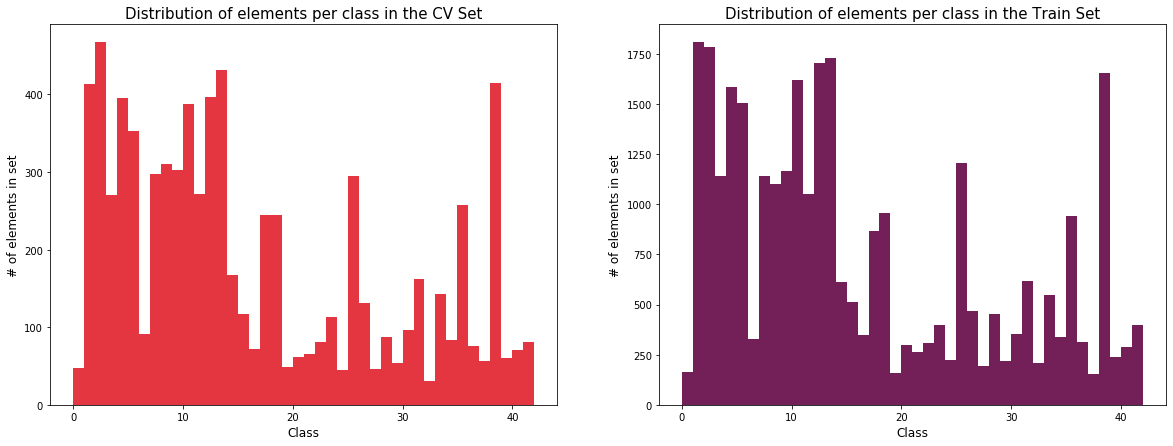

In [68]:
plot_cv_per_class(y_cv,y_train)

#### CV Class Distribution with Equalization

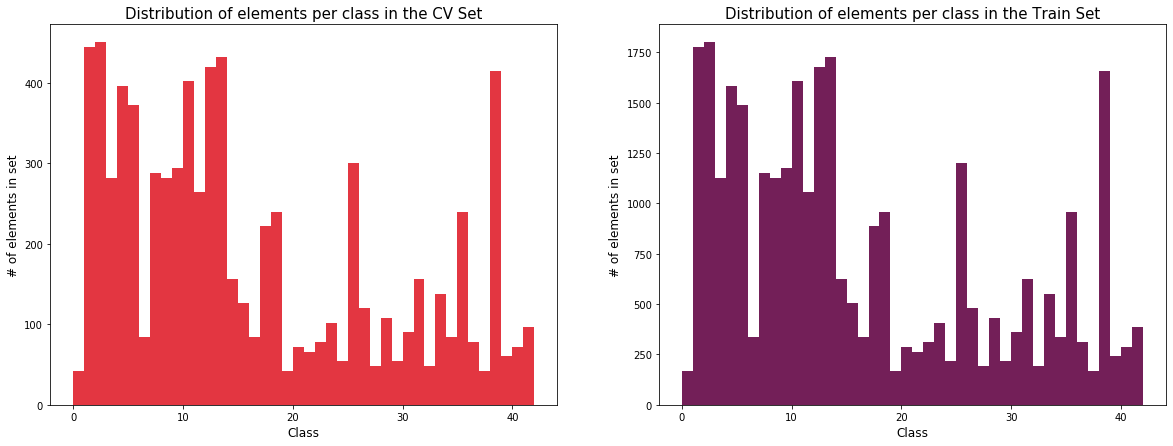

In [75]:
plot_cv_per_class(y_cv,y_train)

#### Accuracy and Cost

In [44]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 87us/sample - loss: 1.8555 - accuracy: 0.9223
Train loss: 0.06068361176813464
Train accuracy: 0.9913606
CV loss: 0.26256666635979714
CV accuracy: 0.97627854
Test loss: 1.8555431108631635
Test accuracy: 0.9223278


#### Conf Matrix

[[ 43  13   0 ...   0   0   0]
 [  0 696   9 ...   0   0   0]
 [  0  13 700 ...   1   0   0]
 ...
 [  0   1   0 ...  85   0   0]
 [  0   0   0 ...   0  51   0]
 [  0   0   0 ...   0   0  81]]


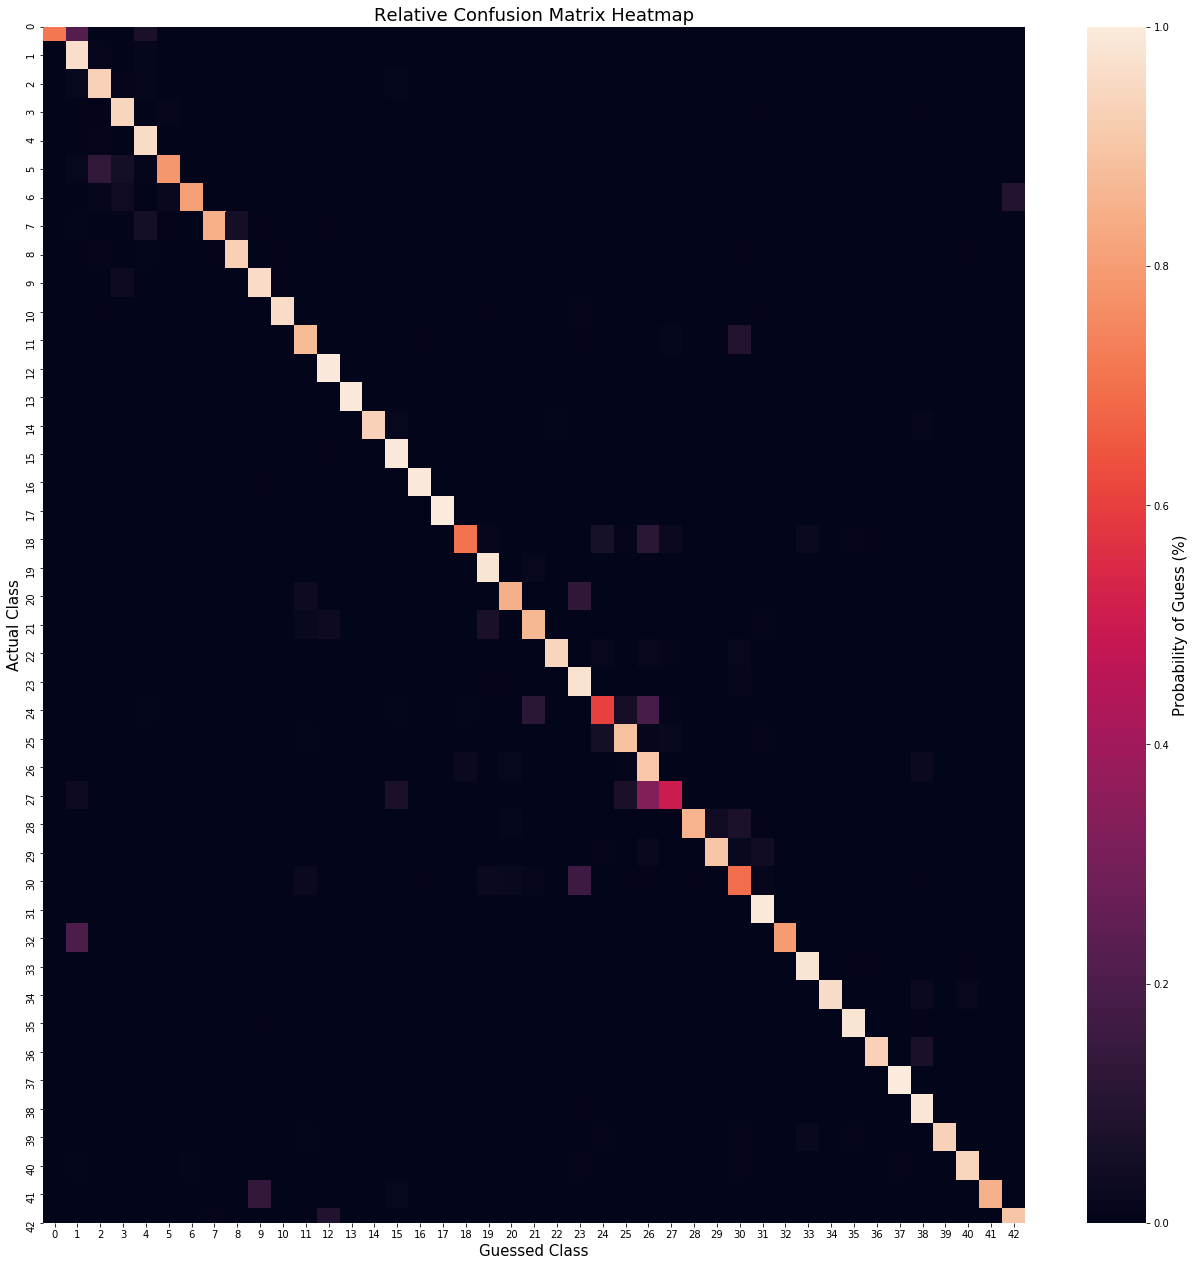

In [45]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

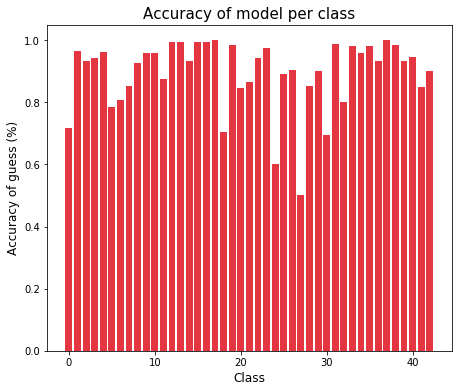

In [46]:
plot_acc_per_class(conf_mat_rel)

### 3 - Grayscale
Convertemos para grayscale. Efetivamente reparamos que em geral o modelo parece estar melhor com as classes mais uniformemente e melhor classificadas corretamente. Porém, em particular as classes 30 a 40 perdem bastante accuracy. Observando as conversões das imagens, efetivamente muitas delas acabar por perder imensa qualidade ficando quase completamente pretas

#### Accuracy and cost

In [41]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 71us/sample - loss: 0.6511 - accuracy: 0.9341
Train loss: 0.03090416154281698
Train accuracy: 0.9923808
CV loss: 0.08111206767492651
CV accuracy: 0.9868639
Test loss: 0.6511055822884229
Test accuracy: 0.9341251


#### Conf Mat

[[ 53   4   0 ...   0   0   0]
 [  0 705   0 ...   2   0   0]
 [  0  27 704 ...   5   0   0]
 ...
 [  0   2   1 ...  75   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0  11  77]]


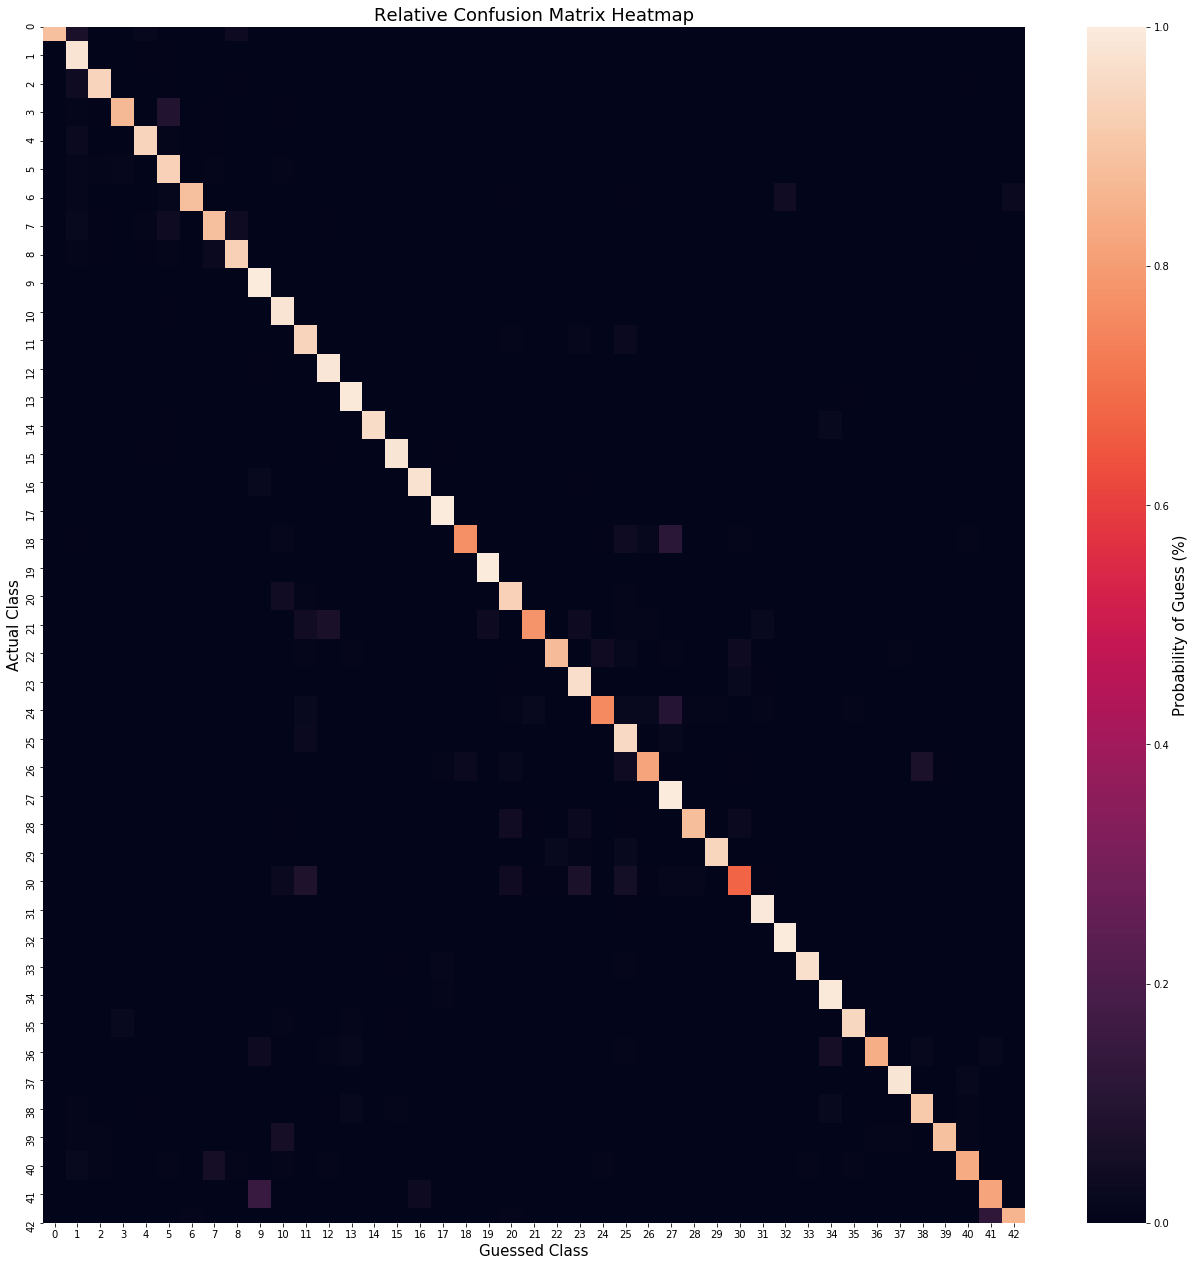

In [42]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

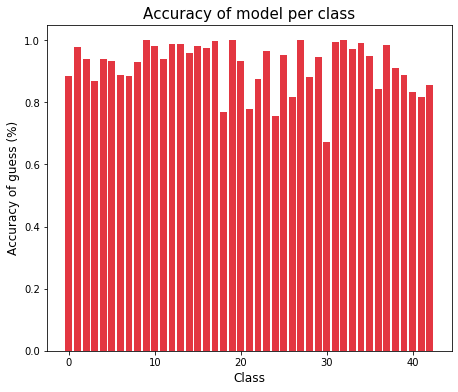

In [43]:
plot_acc_per_class(conf_mat_rel)

### 4 - Normalize and Equalization Algorithms
To try to fix the last problem with grayscale images we tried to use two normalizing techniques: 
- Contrast Limited Adaptive Histogram Equalization
- Histogram Equalization
- CV2's normalization algorithm

### 4.1 - Contrast Limited Adaptative Histogram Equalization
Return image after histogram equalization. Este algoritmo em especifico baseia-se em focar-se em cada zona da imagem para criar uma equalização relativa na zona em questão. O que se verifica é que a accuracy desceu consideravelmente, não justificando o uso deste algoritmo. Cremos que isto seja devido ao facto que o algoritmo esteja a amplificar o background, não só o sinal, que pode confundir o algoritmo 

#### Accuracy and cost

In [28]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 57us/sample - loss: 1.0187 - accuracy: 0.9122
Train loss: 0.028427384311084613
Train accuracy: 0.9919982
CV loss: 0.1696492087726914
CV accuracy: 0.9769162
Test loss: 1.0186666555292698
Test accuracy: 0.9121932


#### Conf Mat

[[ 45  10   0 ...   0   0   0]
 [  1 695  11 ...   0   0   0]
 [  0  14 701 ...   1   0   0]
 ...
 [  0   0   2 ...  73   0   0]
 [  0   0   0 ...   0  48   0]
 [  0   0   0 ...   3   5  79]]


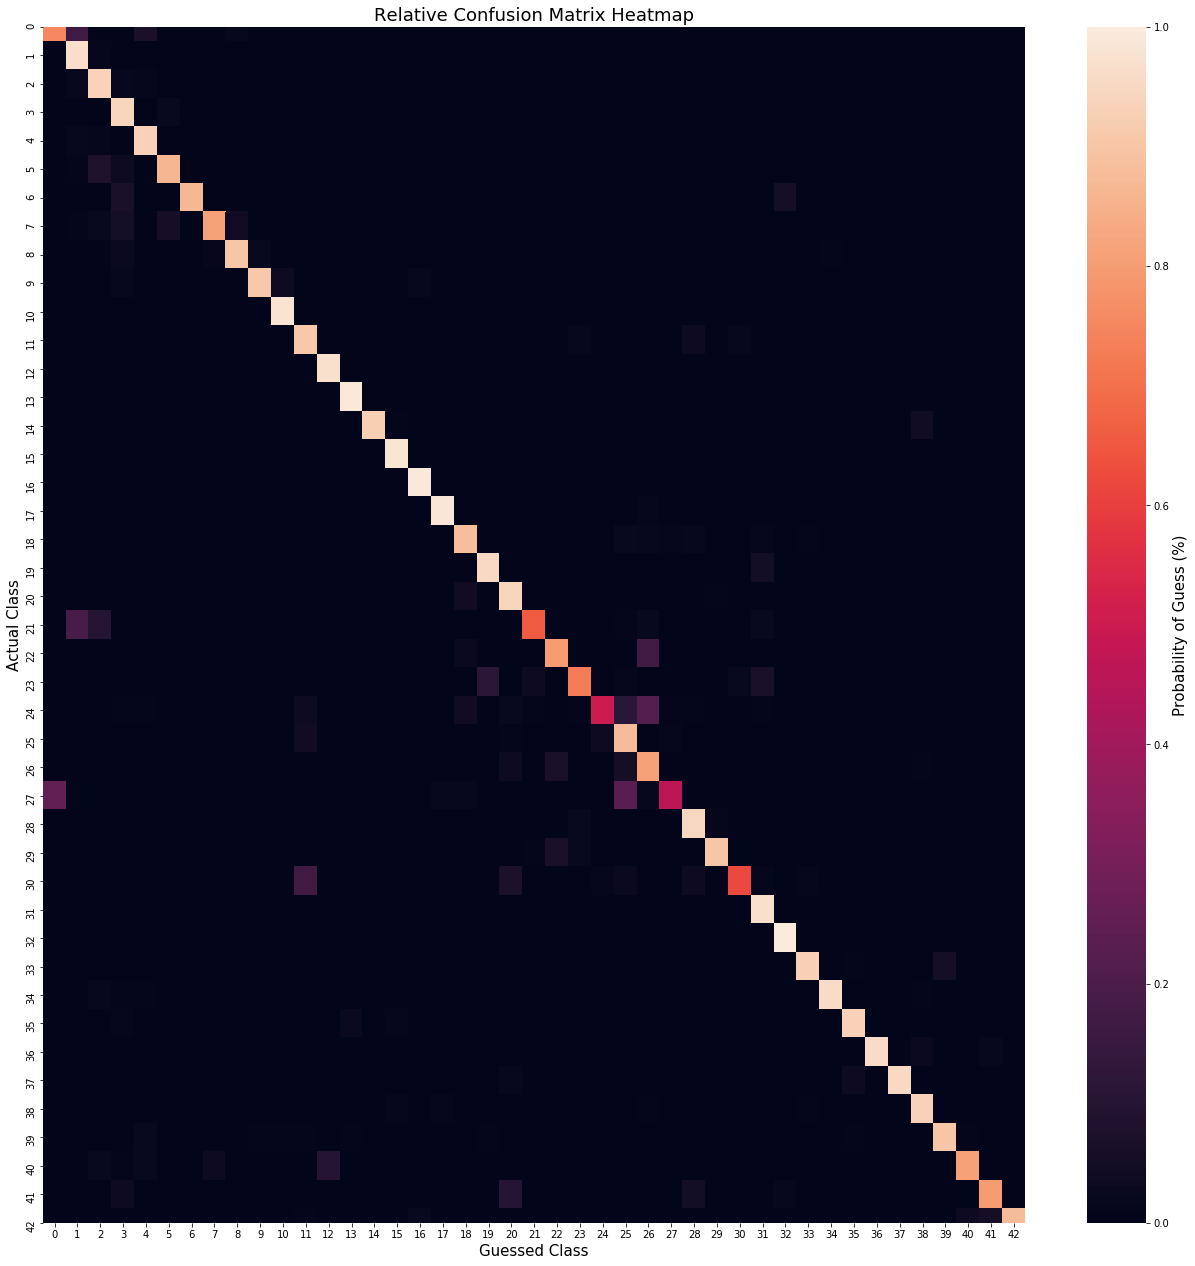

In [29]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

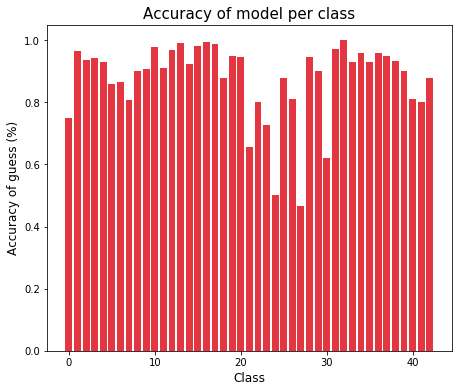

In [30]:
plot_acc_per_class(conf_mat_rel)

### 4.2 - Histogram Equalization
Simple equalization over the entire image.

#### Accuracy and cost

In [35]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 57us/sample - loss: 0.7252 - accuracy: 0.9055
Train loss: 0.013727671238271915
Train accuracy: 0.99553686
CV loss: 0.1320002153411293
CV accuracy: 0.9767887
Test loss: 0.7252057633003602
Test accuracy: 0.9055424


#### Conf Mat

[[ 37  15   0 ...   0   0   0]
 [  1 686  13 ...   0   0   0]
 [  0  10 730 ...   0   0   0]
 ...
 [  0   4   0 ...  64   0   5]
 [  0   0   0 ...   0  55   0]
 [  0   1   0 ...   0   0  89]]


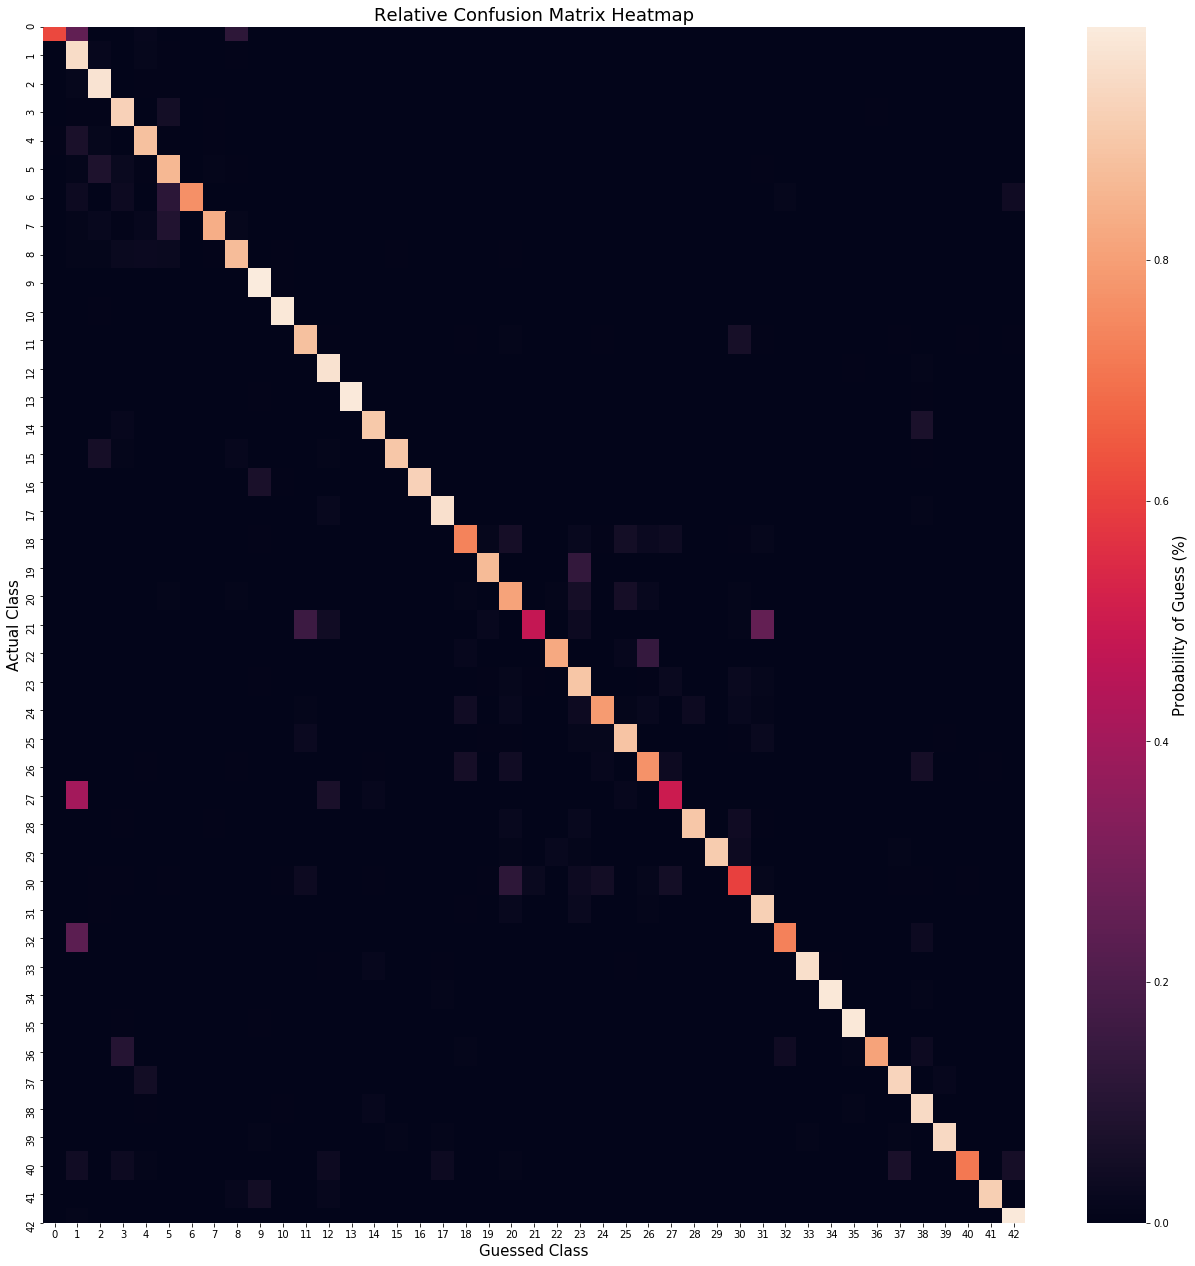

In [36]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

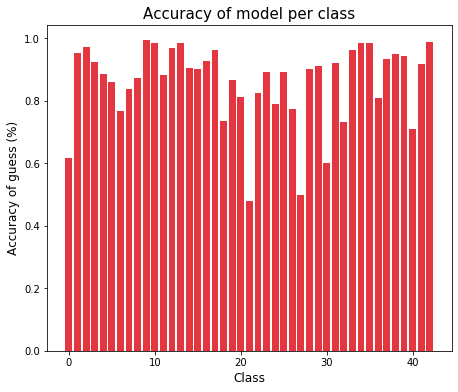

In [37]:
plot_acc_per_class(conf_mat_rel)

### 4.3 - Image Normalization
Simple equalization over the entire image.

#### Global Accuracy

In [64]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 60us/sample - loss: 0.6591 - accuracy: 0.9360
Train loss: 0.012512560527128116
Train accuracy: 0.9967164
CV loss: 0.1027920527138769
CV accuracy: 0.98622626
Test loss: 0.659059932324951
Test accuracy: 0.9360253


#### Conf Mat

[[ 35   0   0 ...   0   0   0]
 [  0 698   3 ...   0   1   0]
 [  0  12 727 ...   0   0   0]
 ...
 [  0   9   1 ...  73   0   0]
 [  0   0   0 ...   0  39   0]
 [  0   0   0 ...   0   1  89]]


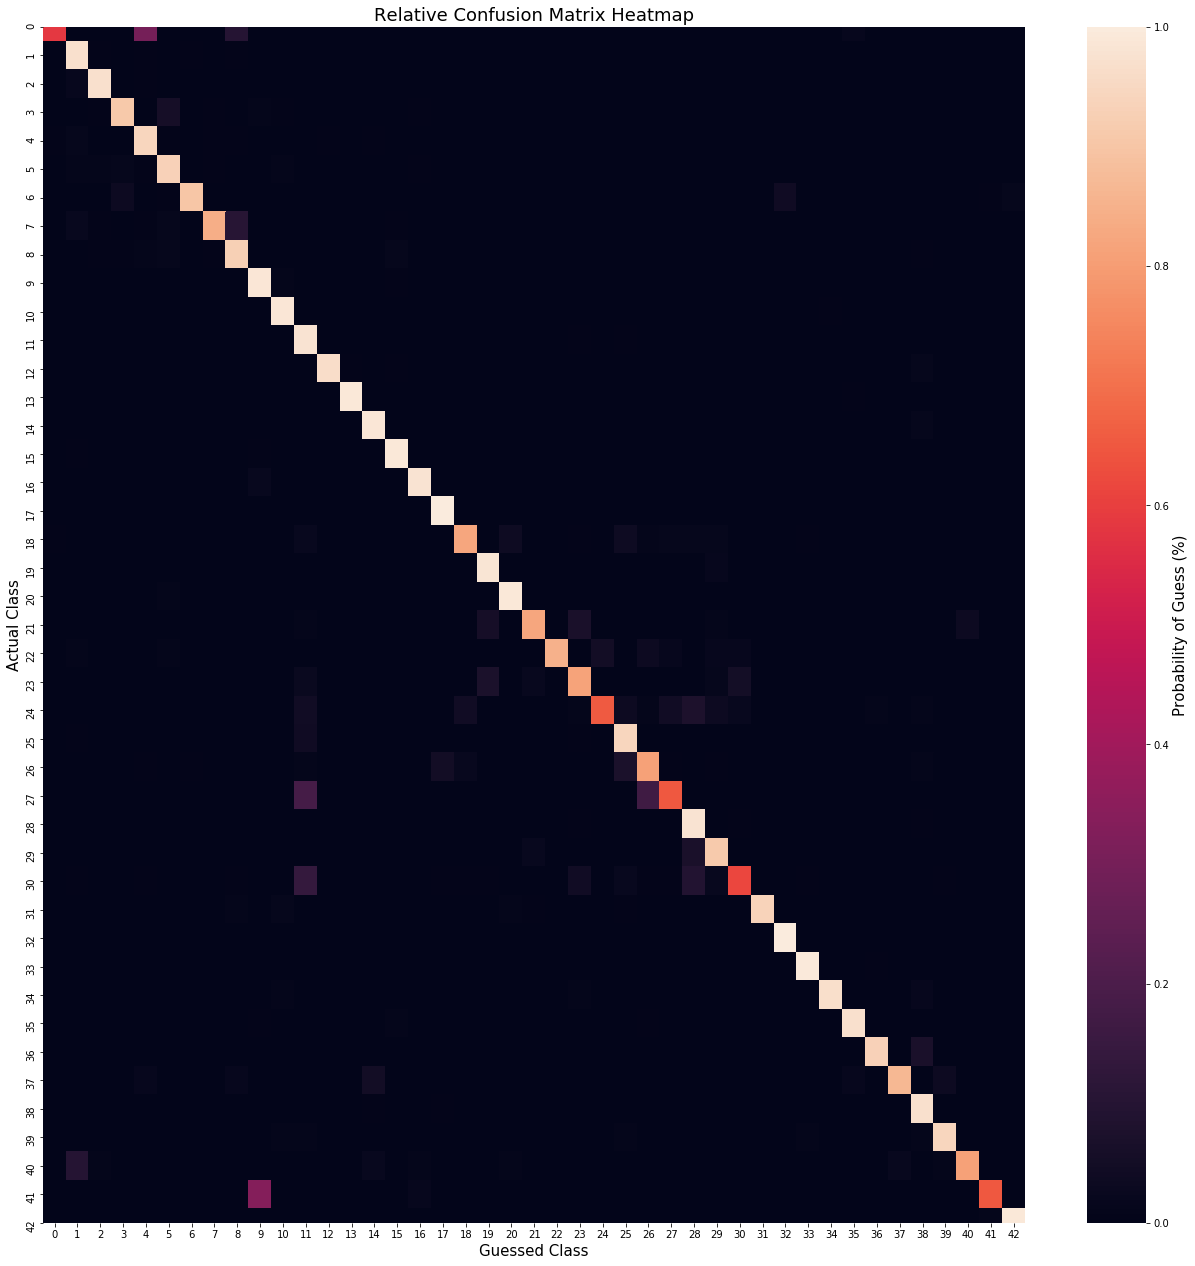

In [65]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

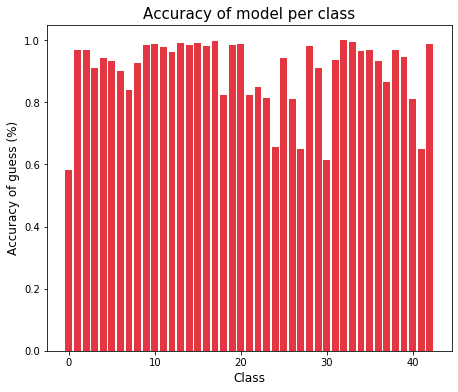

In [66]:
plot_acc_per_class(conf_mat_rel)

### 5 - Contrast
Nota: 
Try this: skimage.exposure.adjust_gamma (e checkout skimage.exposure.is_low_contrast)

#### Global Accuracy

In [16]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 65us/sample - loss: 0.7148 - accuracy: 0.8899
Train loss: 0.006693505189067708
Train accuracy: 0.99795973
CV loss: 0.11181414452724814
CV accuracy: 0.9799771
Test loss: 0.7147907885689634
Test accuracy: 0.88994455


#### Conf Mat

[[ 43   8   0 ...   0   0   0]
 [  2 687  14 ...   0   0   0]
 [  0  17 676 ...   1   1   0]
 ...
 [  0   8   1 ...  69   0   0]
 [  0   0   0 ...   0  45   0]
 [  0   0   0 ...   0  18  67]]


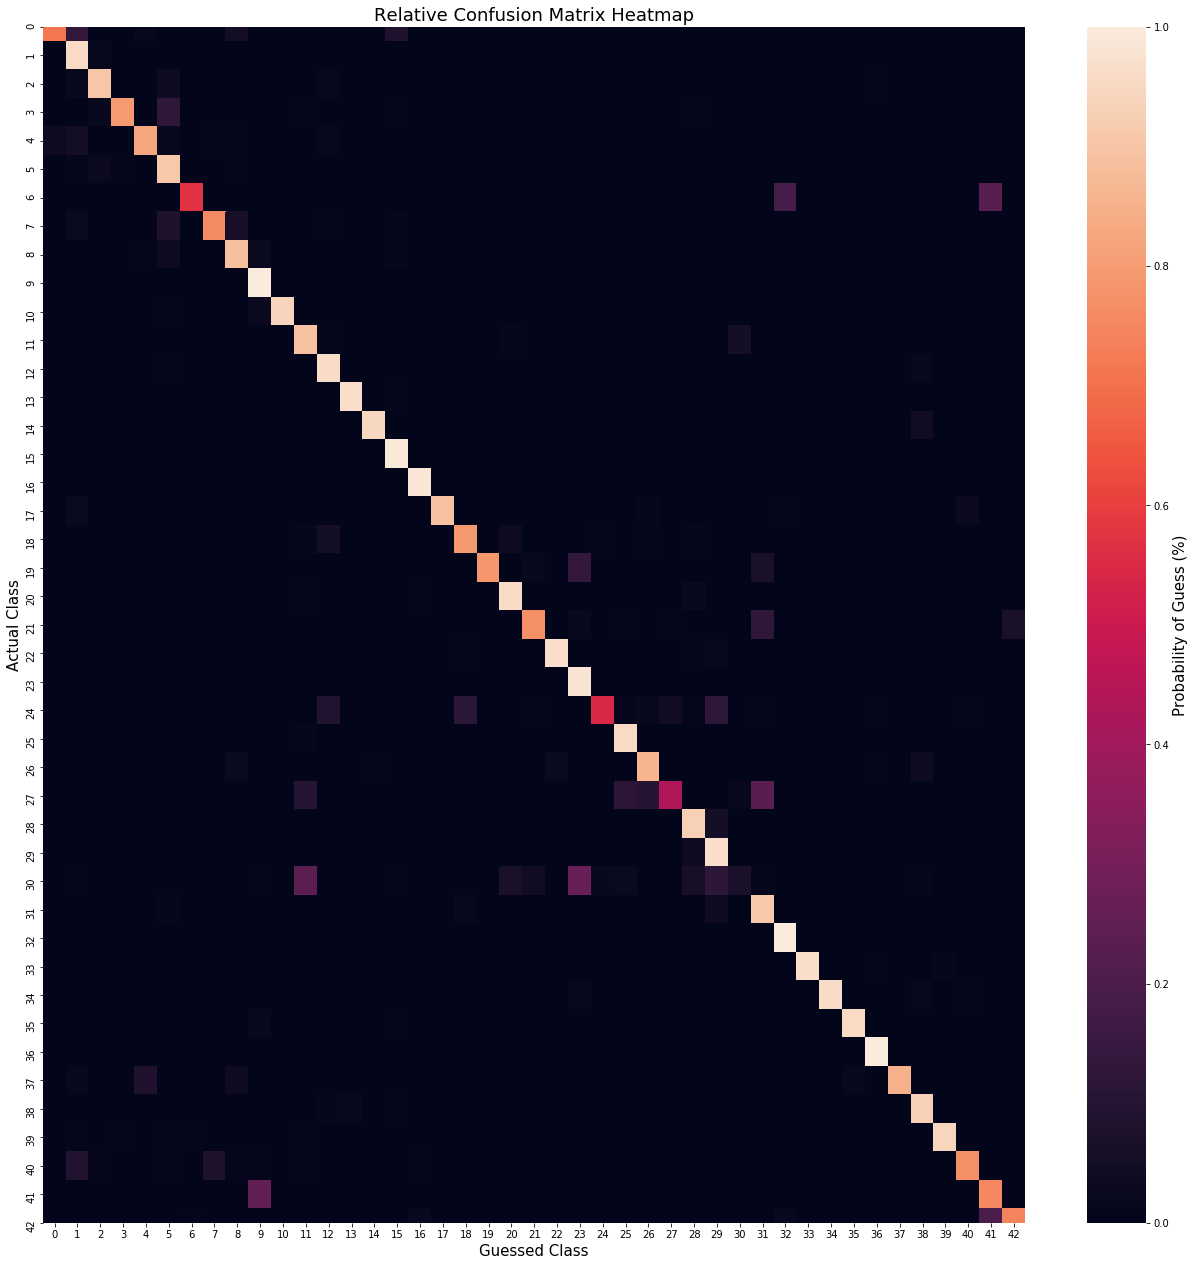

In [17]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

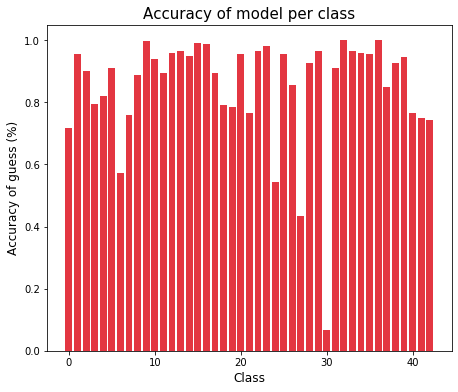

In [18]:
plot_acc_per_class(conf_mat_rel)

### 6 - Data Augmentation

#### CV Class Distribution with Equalization

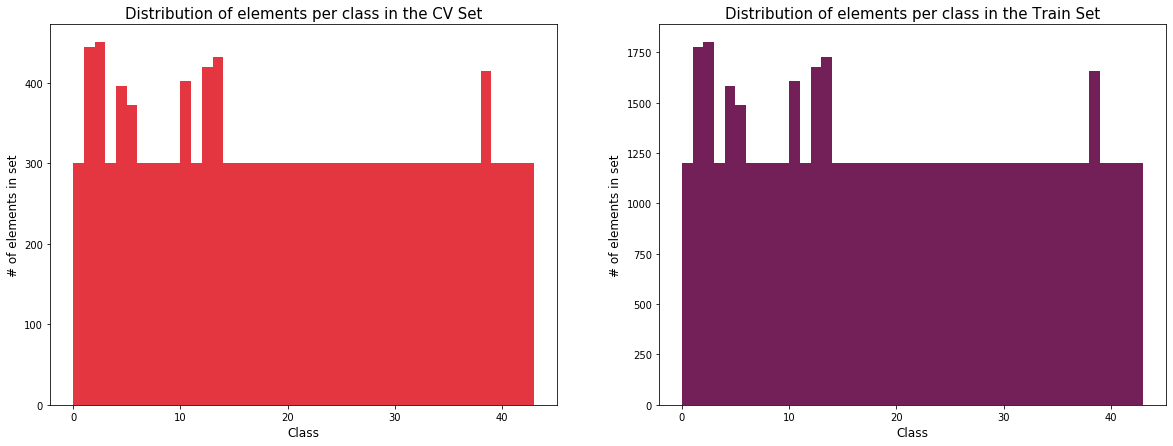

In [70]:
plot_cv_per_class(y_cv,y_train)

#### Global Accuracy

In [82]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Train loss:', history.history['loss'][-1])
print('Train accuracy:', history.history['accuracy'][-1])
print('CV loss:', history.history['val_loss'][-1])
print('CV accuracy:', history.history['val_accuracy'][-1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 83us/sample - loss: 2.8892 - accuracy: 0.9249
Train loss: 0.09540962100309129
Train accuracy: 0.97684383
CV loss: 0.34100636054404126
CV accuracy: 0.9633406
Test loss: 2.889168781619064
Test accuracy: 0.92494065


#### Conf Mat

[[ 43   7   0 ...   0   0   0]
 [  3 686  12 ...   2   0   0]
 [  0  18 704 ...   1   0   0]
 ...
 [  0   2   1 ...  73   0   0]
 [  0   0   0 ...   0  54   0]
 [  0   0   0 ...   0   0  89]]


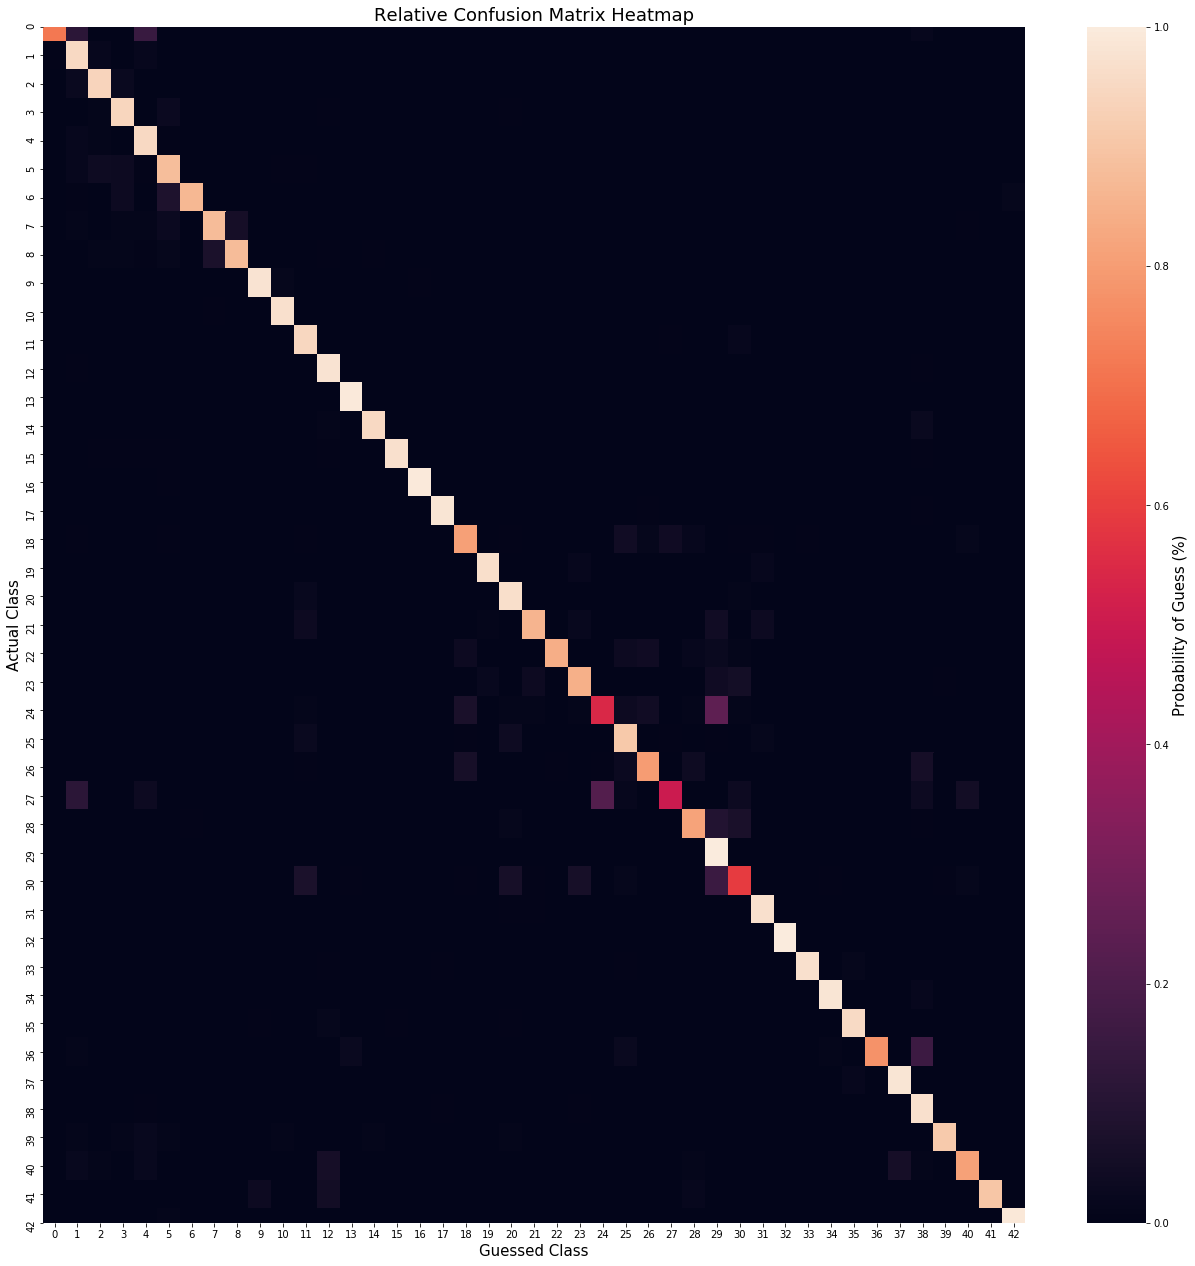

In [83]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per Class

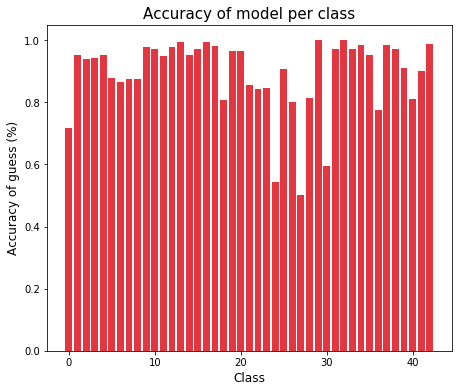

In [84]:
plot_acc_per_class(conf_mat_rel)

### 7 - Epochs


### 8 - Optimizing Function


### 9 - Loss Function


### 10 - Learning Rate

### 11 - Dropout